In [151]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns
#import plotly.express as px
from statsmodels.graphics import tsaplots
from scipy.stats import boxcox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from yahoo_fin.stock_info import get_data
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from arch import arch_model
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import train_test_split
from datetime import timedelta
from scipy.stats import norm
from tabulate import tabulate

# Getting the data

We are using the python lybrary "yahoo_fin" to get the data from the yahoo api

In [152]:
df = get_data("^GSPC")
df.to_csv("df.csv")
df = df.drop('ticker', axis=1)
df.head()

,open,high,low,close,adjclose,volume
1970-03-25,0.0,91.070000,88.110001,89.769997,89.769997,17500000
1970-03-26,0.0,90.650002,89.180000,89.919998,89.919998,11350000
1970-03-30,0.0,90.410004,88.910004,89.629997,89.629997,9600000
1970-03-31,0.0,90.169998,88.849998,89.629997,89.629997,8370000
1970-04-01,0.0,90.620003,89.300003,90.070000,90.070000,9810000


In [153]:
df.describe()


,open,high,low,close,adjclose,volume
count,13572.000000,13572.000000,13572.000000,13572.000000,13572.000000,1.357200e+04
mean,1034.610921,1063.762776,1050.721749,1057.665675,1057.665675,1.578380e+09
std,1133.686049,1119.639795,1106.956277,1113.697269,1113.697269,1.869603e+09
min,0.000000,63.230000,60.959999,62.279999,62.279999,6.650000e+06
25%,157.907501,158.625000,157.122505,157.987503,157.987503,8.101500e+07
50%,754.924988,758.545013,747.745026,754.924988,754.924988,4.716650e+08
75%,1397.194977,1404.482483,1386.692444,1397.749969,1397.749969,3.278608e+09
max,4804.509766,4818.620117,4780.979980,4796.560059,4796.560059,1.145623e+10


# Analyzing the time series
Now that we have the data we can start analyzing it
## Time series Plots

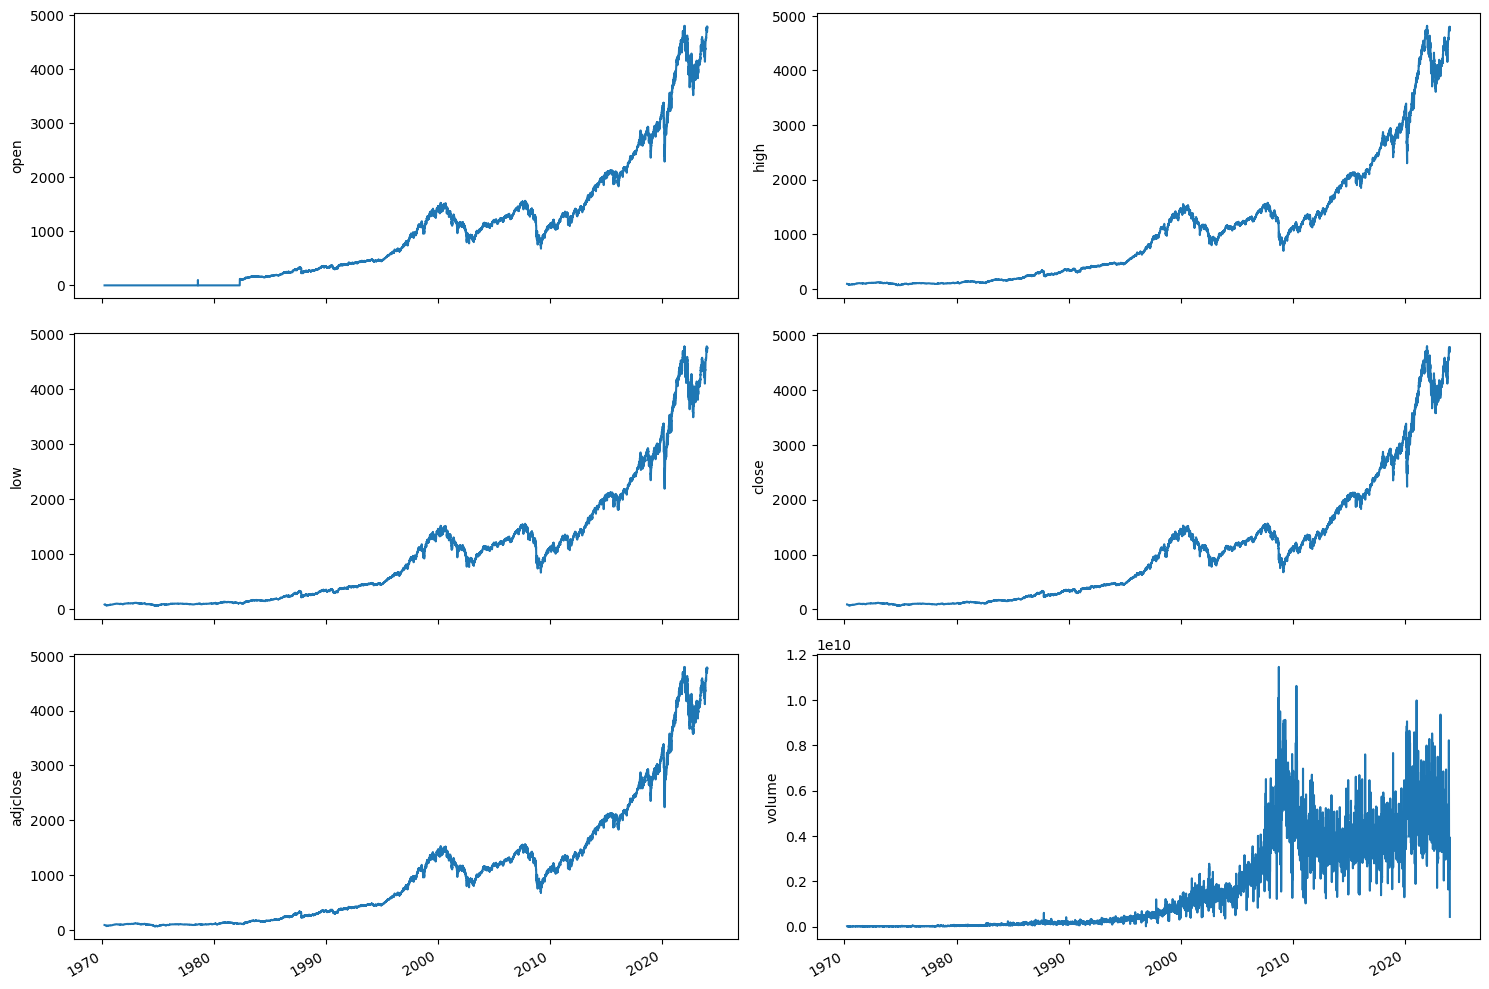

In [154]:
labels = df.columns.values

plt.figure(figsize=(15,10))
p = 1
for label in labels:
    plt.subplot(3,2,p)
    p +=1
    plt.plot(df.index,df[label])
    plt.ylabel(label)
    date_format = mdates.DateFormatter("%Y")
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

## Chossing variable to study

Because our data has multiple variables we need to decide on one to study we decided to use the variable "adjclose".

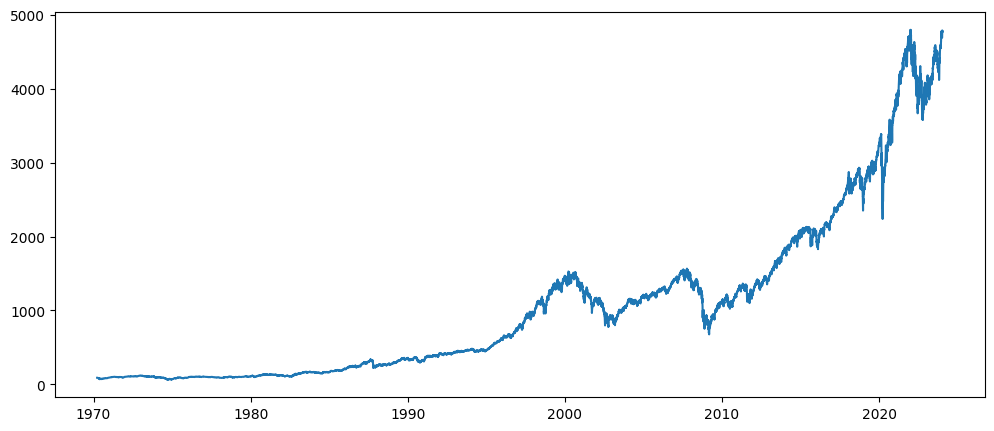

In [155]:
var = 'adjclose'
plt.figure(figsize=(12,5))
plt.plot(df.index,df[var])
plt.show()

## Decomposing the time series

In [156]:
def seasonal_decomposition(df, column_name):

    result_mul = seasonal_decompose(df[column_name], model='multiplicative', period=12, extrapolate_trend='freq')
    result_add = seasonal_decompose(df[column_name], model='additive', period=12, extrapolate_trend='freq')
    
    return result_mul, result_add

def plot_decompostion(df, column_name, decomposition):
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(df[column_name], label='Original TS')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(decomposition.seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual')
    plt.legend(loc='best')
    plt.show()

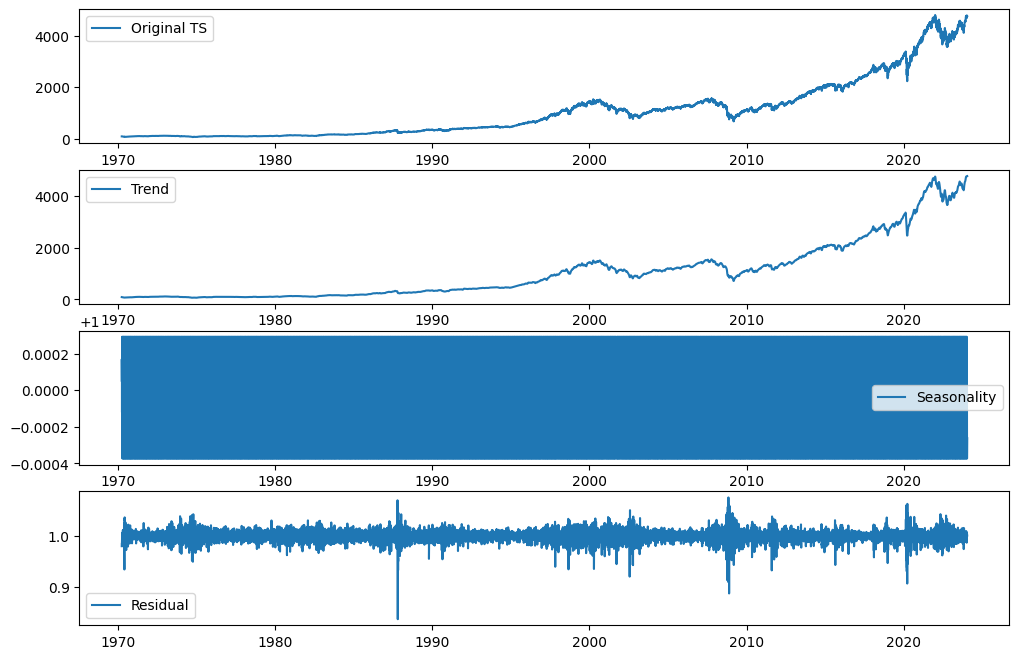

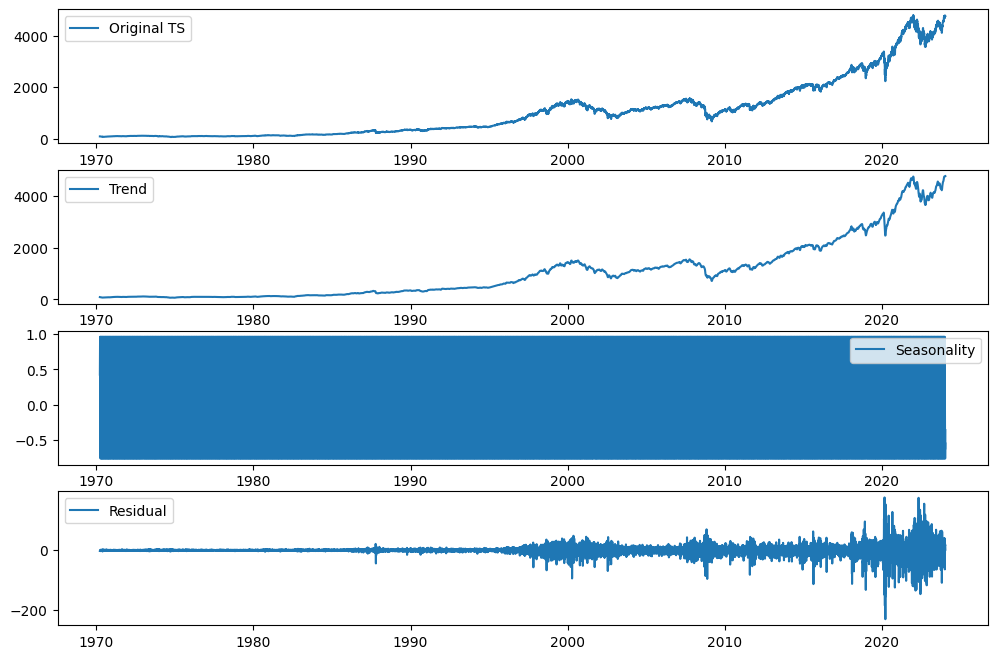

In [157]:
result_mult, result_add = seasonal_decomposition(df,var)

plot_decompostion(df,var,result_mult)
plot_decompostion(df,var,result_add)


### Auto-correlation function of the residuals of the decomposition

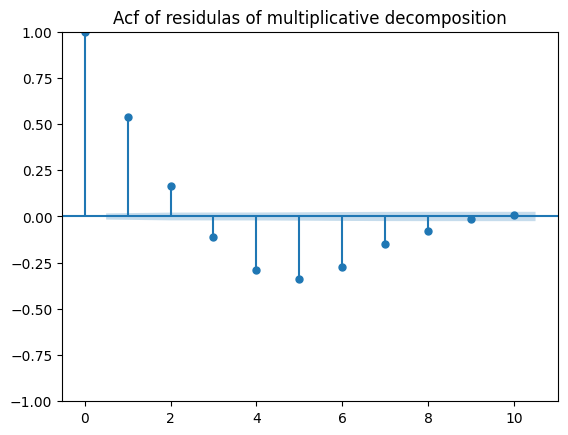

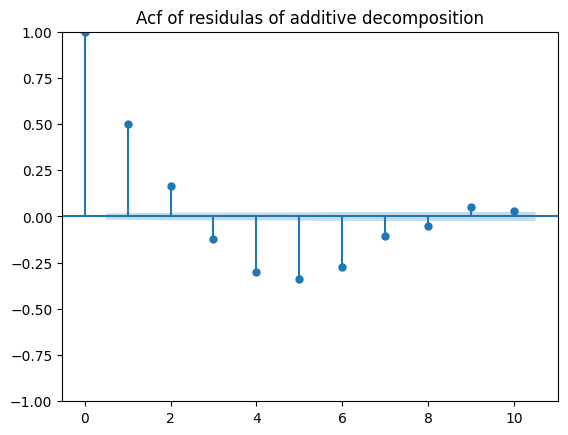

In [158]:
fig = tsaplots.plot_acf(result_mult.resid, lags=10)
plt.title('Acf of residulas of multiplicative decomposition')
plt.show()

fig = tsaplots.plot_acf(result_add.resid, lags=10)
plt.title('Acf of residulas of additive decomposition')
plt.show()

## Lag plots

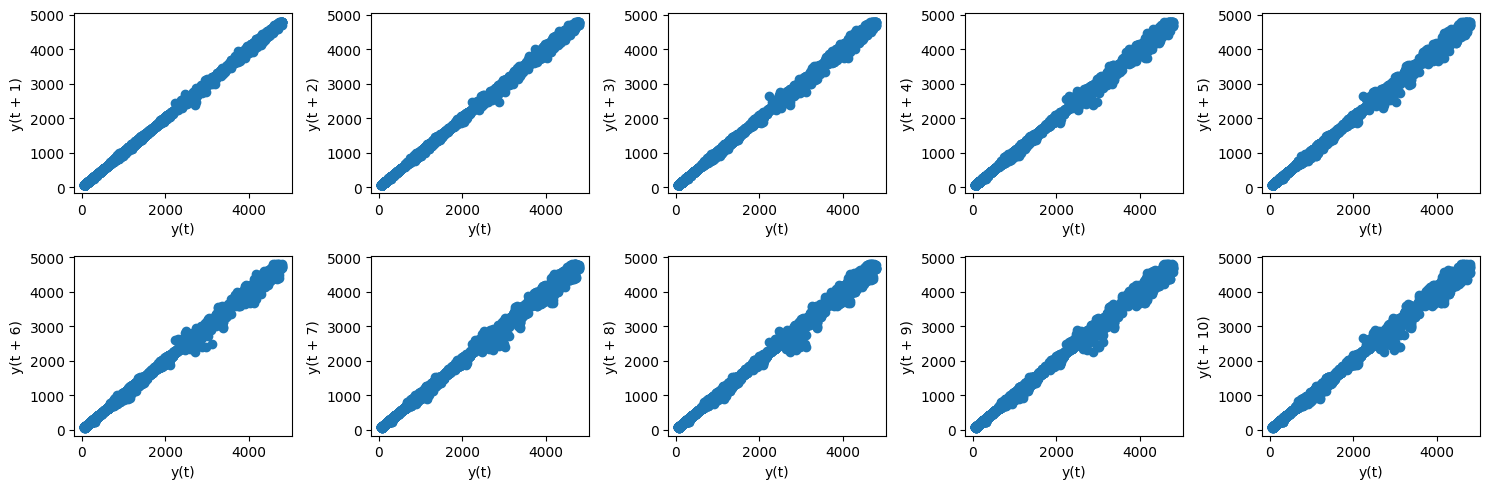

In [159]:
plt.figure(figsize=(15,5))
for i in range(1,11):
    plt.subplot(2,5,i)
    pd.plotting.lag_plot(df[var],lag=i)

plt.tight_layout()
plt.show()


## ACF Plot

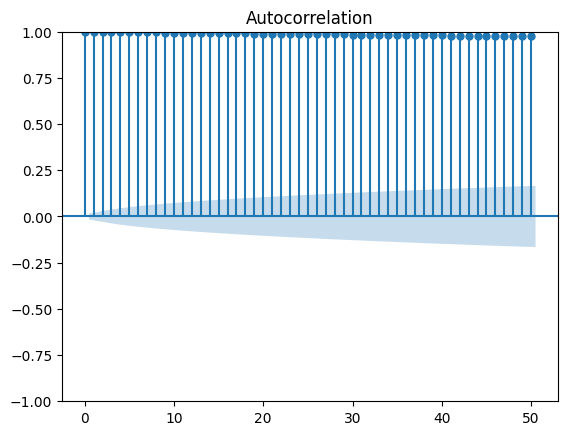

[1.         0.99944308 0.99890391 0.99835735 0.99781354 0.99728346
 0.99674792 0.99624296 0.99572055 0.99521267 0.99467332]


In [160]:
acf= sm.tsa.acf(df[var],nlags=10)
fig = tsaplots.plot_acf(df[var], lags=50)
plt.show()
print(acf)

# Analysing the daily difference

In [161]:
daily_diff = df.diff()
daily_diff = daily_diff.dropna()
daily_diff.describe()


,open,high,low,close,adjclose,volume
count,13571.000000,13571.000000,13571.000000,13571.000000,13571.000000,1.357100e+04
mean,0.351658,0.344947,0.343657,0.344924,0.344924,3.030845e+04
std,15.679707,13.589435,15.350580,17.218516,17.218516,4.467219e+08
min,-194.739990,-164.650146,-228.359863,-324.890137,-324.890137,-5.044220e+09
25%,-1.700027,-1.539978,-1.680031,-1.869995,-1.869995,-3.938500e+07
50%,0.000000,0.110001,0.190002,0.139999,0.139999,0.000000e+00
75%,2.969986,2.500000,2.869995,2.934998,2.934998,3.790000e+07
max,170.039795,148.979980,172.180176,230.380127,230.380127,4.637230e+09


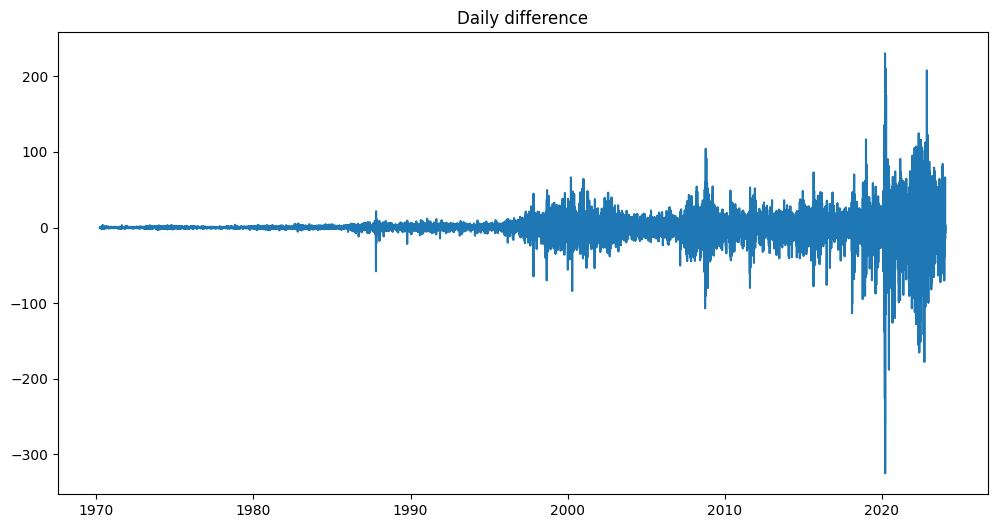

In [162]:
plt.figure(figsize=(12,6))
#plt.scatter(monthly_diff.index,monthly_diff[var])
plt.plot(daily_diff.index,daily_diff[var])
plt.title('Daily difference')
plt.show()

## Check for stationary

In [163]:
result = adfuller(daily_diff[var])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("The time series is stationary.\n\n")
else:
    print("The time series is non-stationary.\n\n")

result = kpss(daily_diff[var])
print('KPSS Statistic:', result[0])
print('p-value:', result[1])

if result[1] <= 0.05:
    print("The time series is non-stationary.")
else:
    print("The time series is stationary.")

ADF Statistic: -20.033787891694537
p-value: 0.0
Critical Values: {'1%': -3.430833446017894, '5%': -2.861753660520076, '10%': -2.566883726633754}
The time series is stationary.


KPSS Statistic: 0.7591090861837849
p-value: 0.01
The time series is non-stationary.


C:\Users\GODA\AppData\Local\Temp\ipykernel_12760\3128835151.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(daily_diff[var])


## ACF of daily differences

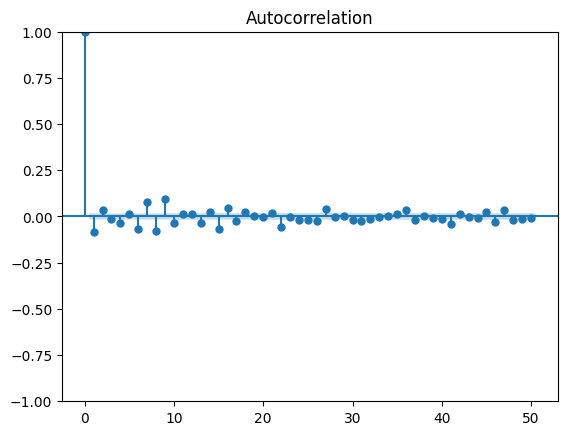

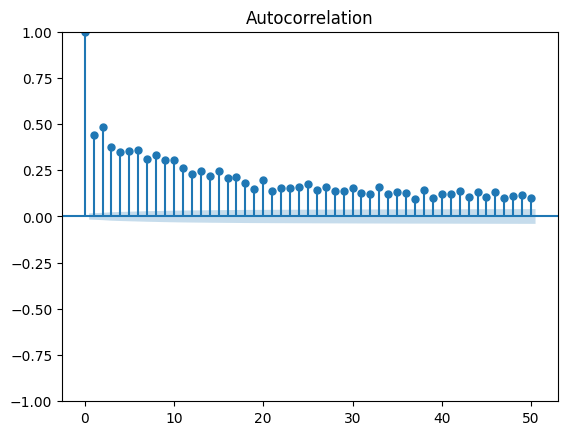

In [164]:
tsaplots.plot_acf(daily_diff[var], lags=50)
plt.show()

returns_sqr = map(lambda x: x*x , daily_diff[var])

tsaplots.plot_acf(list(returns_sqr), lags=50)
plt.show()

# tsaplots.plot_pacf(daily_diff[var],lags=50)
# plt.show()

## Lag plots of daily differences

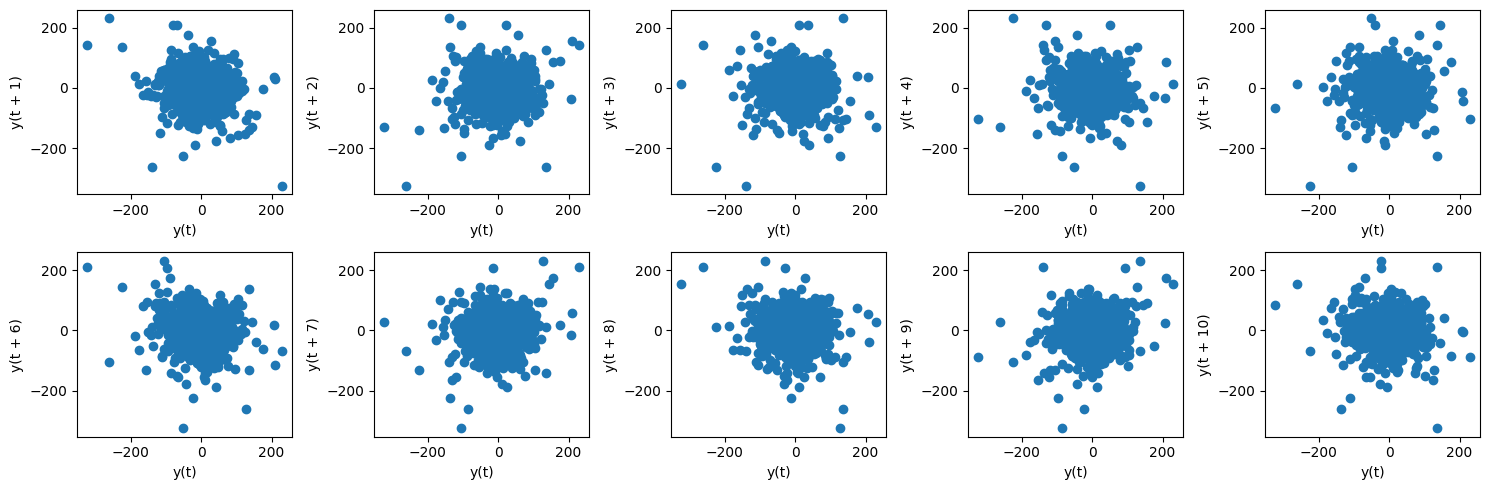

In [165]:
plt.figure(figsize=(15,5))
for i in range(1,11):
    plt.subplot(2,5,i)
    pd.plotting.lag_plot(daily_diff[var],lag=i)

plt.tight_layout()
plt.show()

## Decomposition of daily differences

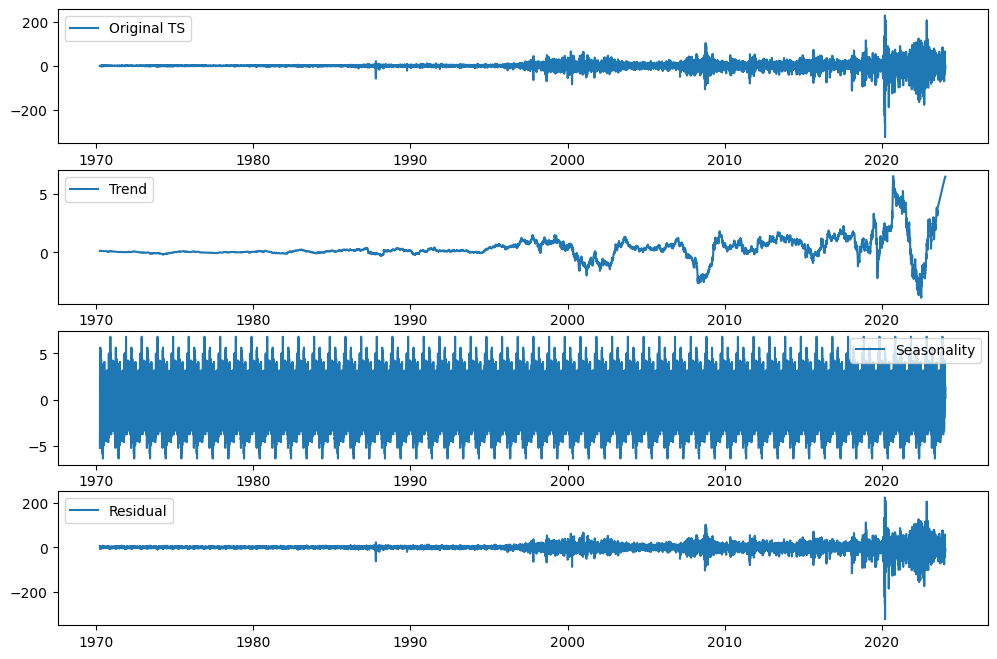

In [166]:
result_add = seasonal_decompose(daily_diff[var], model='additive',period=252, extrapolate_trend='freq' )

plot_decompostion(daily_diff,var,result_add)

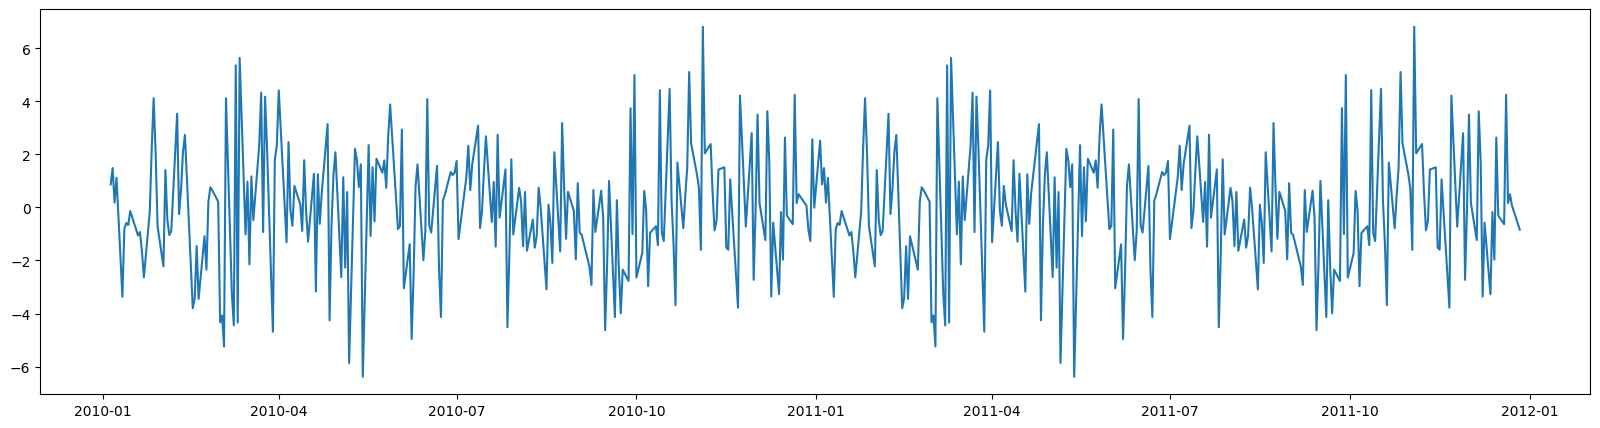

In [167]:
plt.figure(figsize=(20,5))
plt.plot(result_add.seasonal[10040:10540], label='Residual')
plt.show()

# Analysing the data monthly

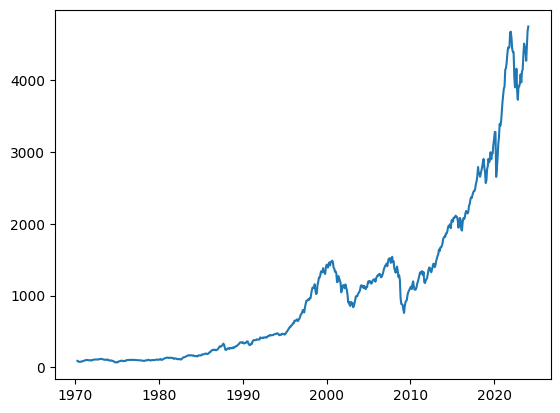

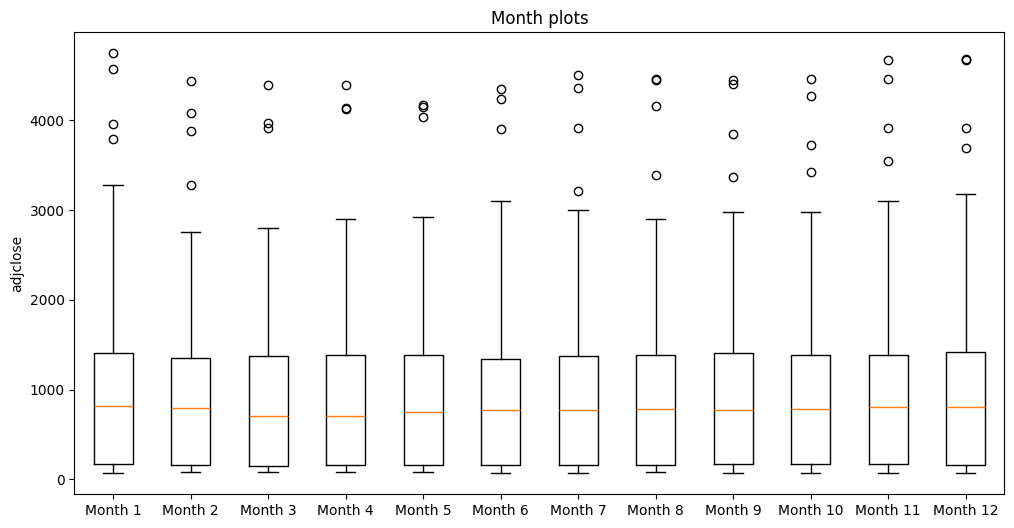

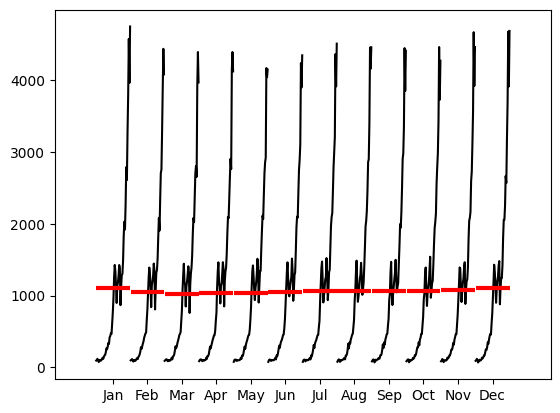

In [168]:
monthly_data = df.resample('M').mean()

plt.plot(monthly_data.index,monthly_data[var])
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))

data_boxplots = [group[var].values for month, group in monthly_data.groupby(monthly_data.index.month)]

ax.boxplot(data_boxplots, labels=[f'Month {month}' for month in range(1, 13)])
ax.set_ylabel(var)
ax.set_title('Month plots')

plt.show()

fig = sm.graphics.tsa.month_plot(monthly_data[var])
plt.show()


## The evolution of the monthly difference

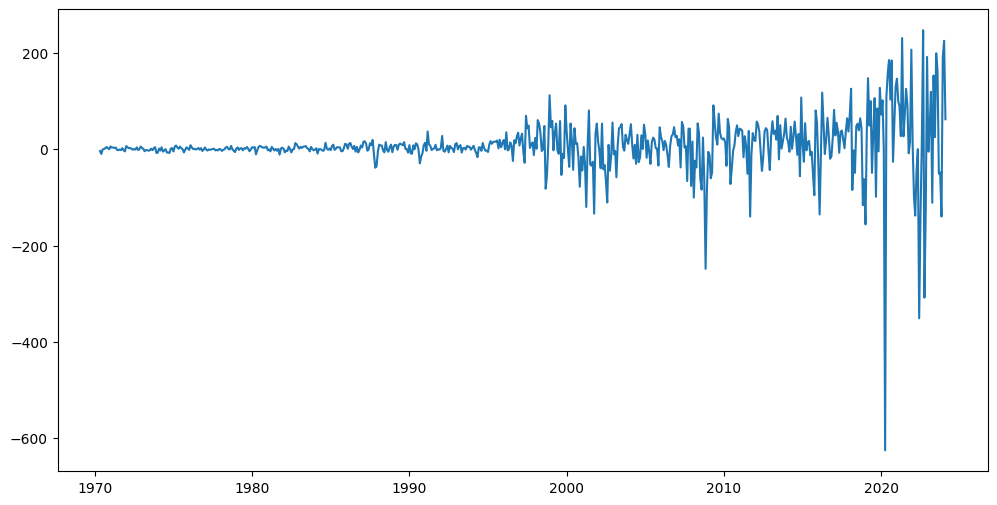

In [169]:
monthly_diff = monthly_data.diff()

plt.figure(figsize=(12,6))
#plt.scatter(monthly_diff.index,monthly_diff[var])
plt.plot(monthly_diff.index,monthly_diff[var])
plt.show()

# Analysing the box-cox transformation

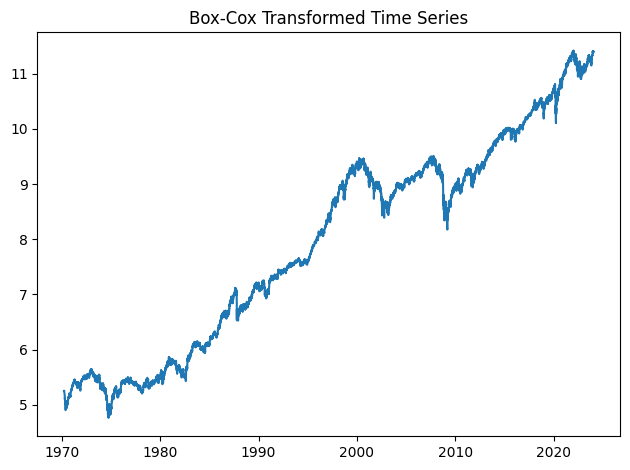

Optimal lambda value: 0.06714652331947589


In [170]:
transformed_values, lambda_value = boxcox(df[var])

plt.plot(df.index, transformed_values)
plt.title('Box-Cox Transformed Time Series')

plt.tight_layout()
plt.show()

print(f'Optimal lambda value: {lambda_value}')

## Decomposition of box-cox transformation

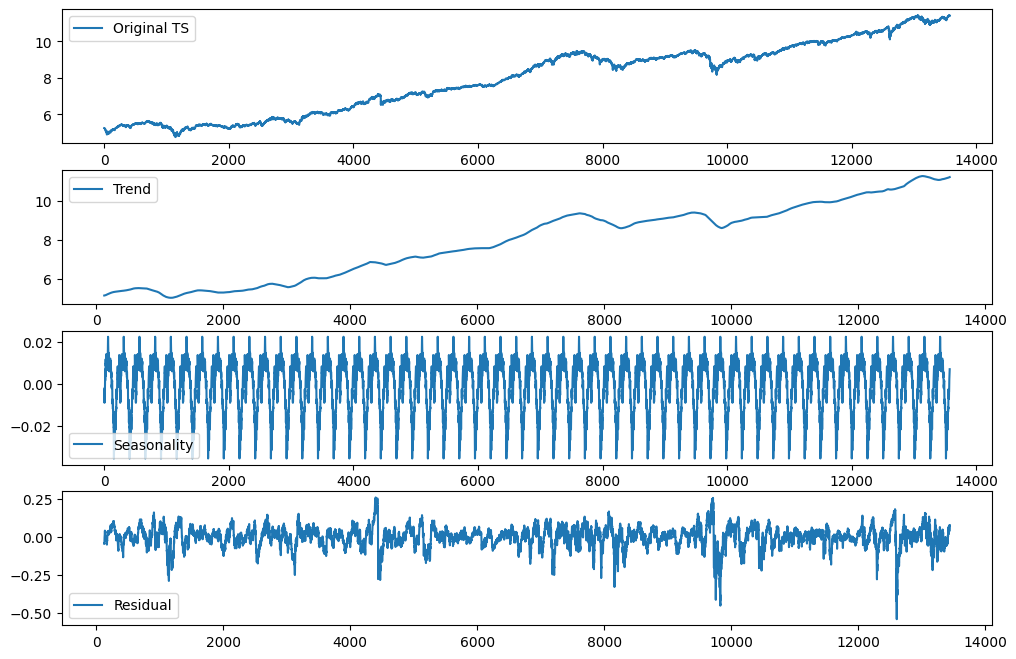

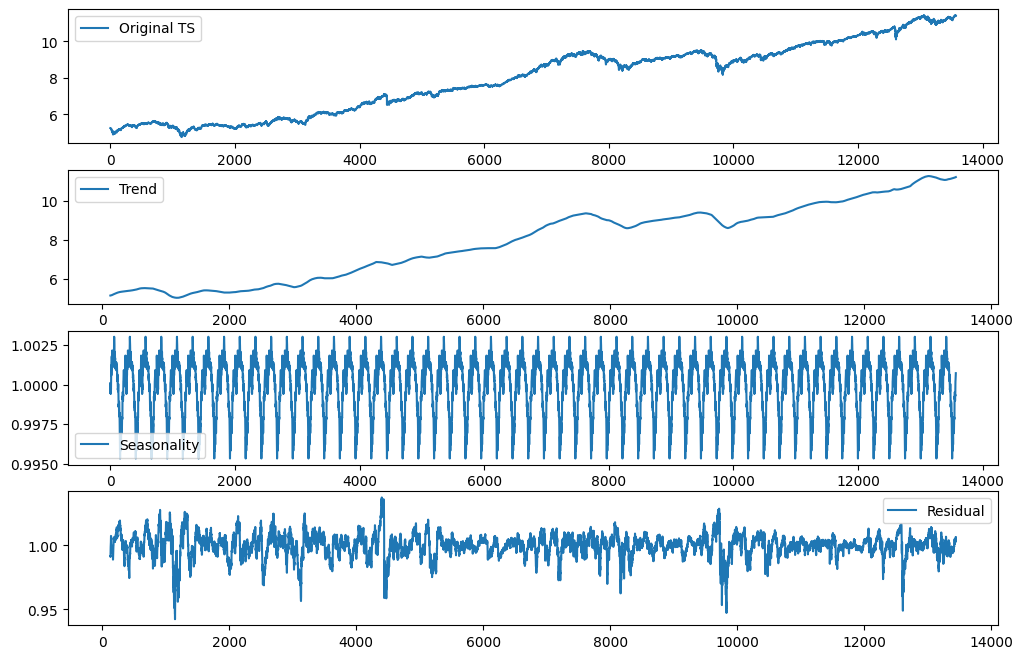

In [171]:
decompose_add=seasonal_decompose(transformed_values, model='additive', period=252)
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(transformed_values, label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_add.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_add.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_add.resid, label='Residual')
plt.legend(loc='best')

plt.show()

decompose_mult=seasonal_decompose(transformed_values, model='multiplicative', period=252)
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(transformed_values, label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_mult.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_mult.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_mult.resid, label='Residual')
plt.legend(loc='best')

plt.show()

## Lag plots of box-cox transformation

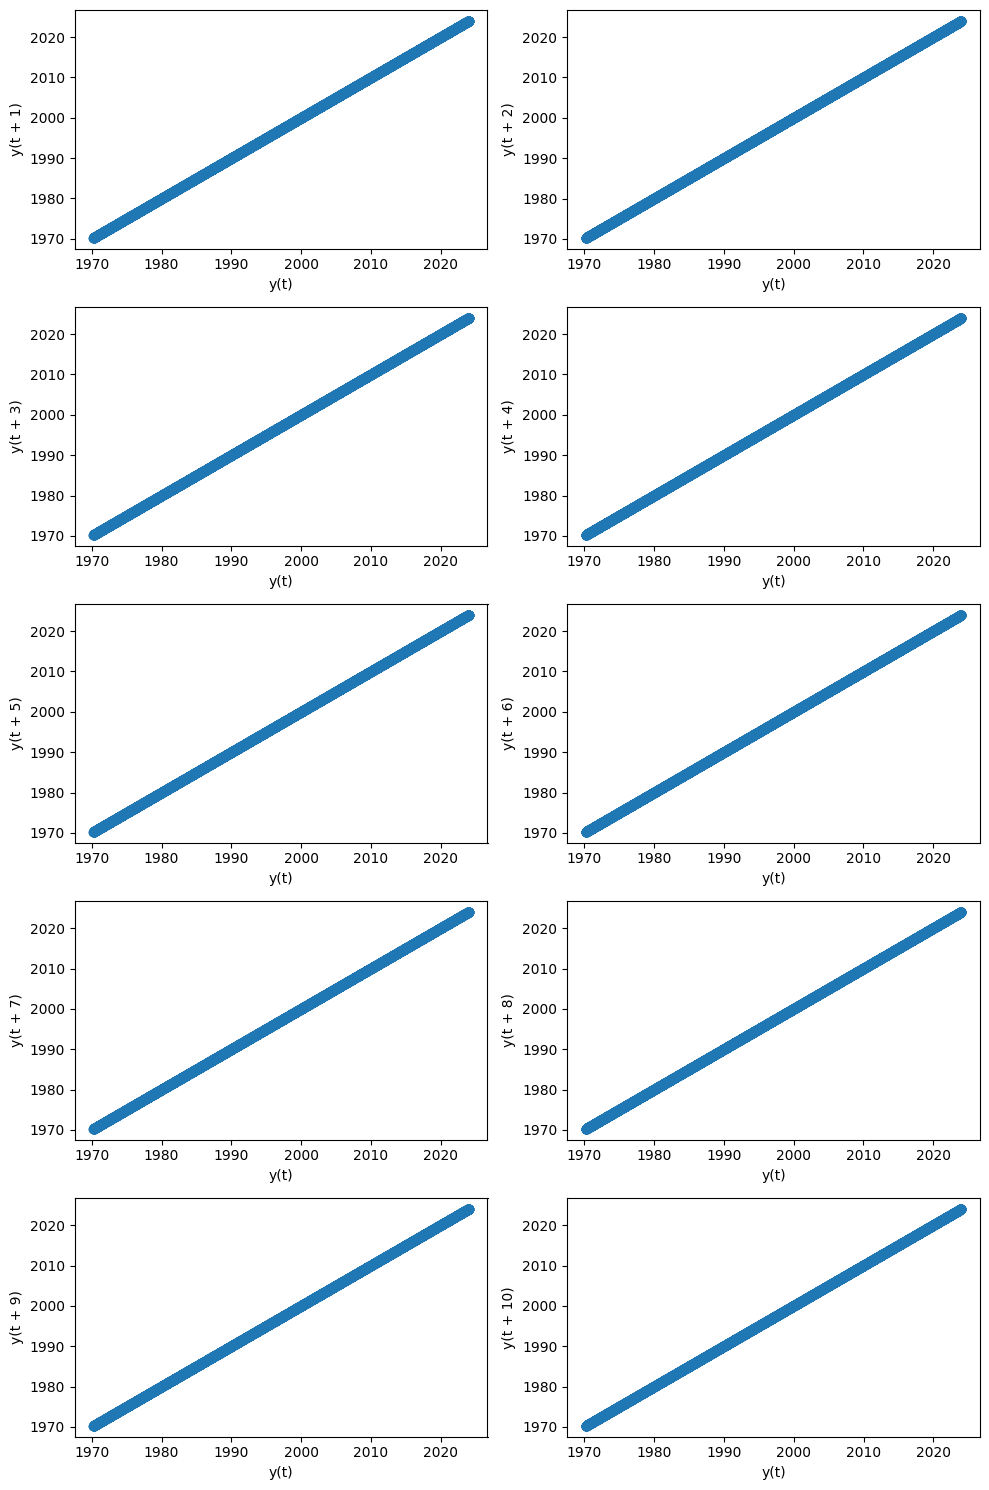

In [172]:
transformed_df = pd.Series(df.index,transformed_values)

plt.figure(figsize=(10,15))
for i in range(1,11):
    plt.subplot(5,2,i)
    pd.plotting.lag_plot(transformed_df,lag=i)

plt.tight_layout()
plt.show()

## ACF of box-cox transformation

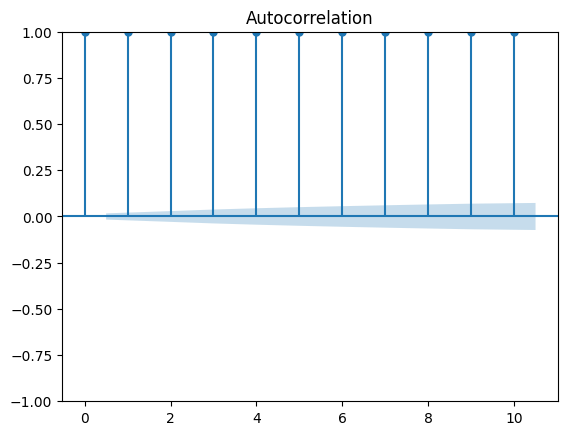

In [173]:
acf= sm.tsa.acf(transformed_values)
fig = tsaplots.plot_acf(transformed_values, lags=10)
plt.show()

In [174]:
daily_diff.describe()

,open,high,low,close,adjclose,volume
count,13571.000000,13571.000000,13571.000000,13571.000000,13571.000000,1.357100e+04
mean,0.351658,0.344947,0.343657,0.344924,0.344924,3.030845e+04
std,15.679707,13.589435,15.350580,17.218516,17.218516,4.467219e+08
min,-194.739990,-164.650146,-228.359863,-324.890137,-324.890137,-5.044220e+09
25%,-1.700027,-1.539978,-1.680031,-1.869995,-1.869995,-3.938500e+07
50%,0.000000,0.110001,0.190002,0.139999,0.139999,0.000000e+00
75%,2.969986,2.500000,2.869995,2.934998,2.934998,3.790000e+07
max,170.039795,148.979980,172.180176,230.380127,230.380127,4.637230e+09


# Model

Conditional Variance:

The GARCH model assumes that the variance of the financial time series is not constant over time but depends on past observations. The conditional variance at each time point is the estimated volatility given the available information up to that point.

Volatility:

In the GARCH context, volatility is often used interchangeably with conditional variance. It characterizes the magnitude of potential fluctuations in the returns of a financial asset.

In [175]:
returns = df['adjclose'].pct_change()
returns = returns[1:] *100
print(returns)
returns_sqr = list(map(lambda x:x*x,returns))

1970-03-26    0.167095
1970-03-30   -0.322510
1970-03-31    0.000000
1970-04-01    0.490910
1970-04-02   -0.310868
                ...   
2024-01-09   -0.147790
2024-01-10    0.566597
2024-01-11   -0.067106
2024-01-12    0.075098
2024-01-16   -0.273841
Name: adjclose, Length: 13571, dtype: float64


Returns


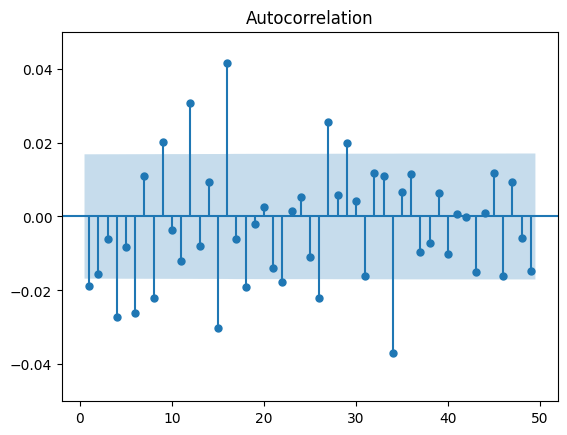

[ 1.         -0.0188138  -0.0156806  -0.0061216  -0.0270667  -0.00832895
 -0.02621774  0.01095665 -0.02207658  0.0201679  -0.00360394]


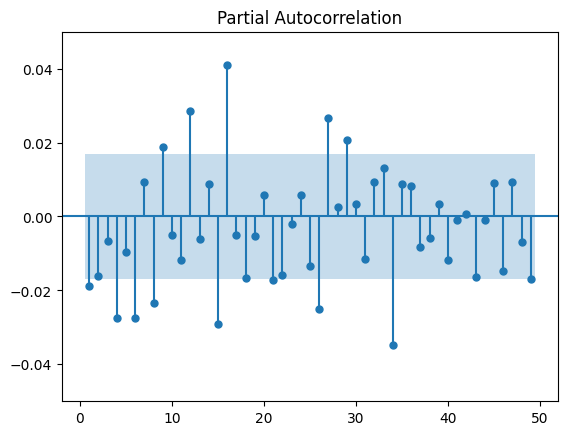

[ 1.         -0.01881518 -0.0160426  -0.00672872 -0.02759073 -0.00960589
 -0.02754844  0.0092581  -0.02352448  0.018814   -0.00509562]


In [176]:
print("Returns")
acf= sm.tsa.acf(returns,nlags=10)
fig = tsaplots.plot_acf(returns, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)

pacf= sm.tsa.pacf(returns,nlags=10)
fig = tsaplots.plot_pacf(returns, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

Returns square


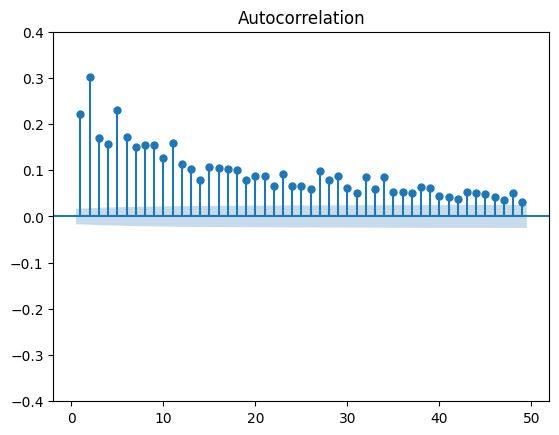

[1.         0.22139377 0.30176813 0.168816   0.15719599 0.23097934
 0.17192924 0.15129483 0.15471457 0.15538627 0.12712655]


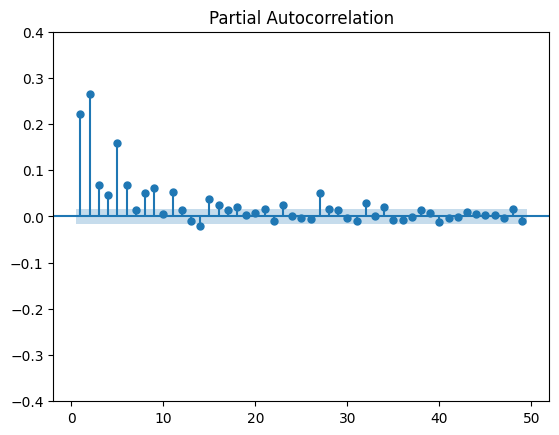

[1.         0.22141008 0.26582139 0.06895012 0.04636029 0.15818012
 0.06797892 0.01390337 0.0503055  0.06209712 0.00599485]


In [177]:
print("Returns square")
acf= sm.tsa.acf(returns_sqr,nlags=10)
fig = tsaplots.plot_acf(returns_sqr, lags=range(1,50))
plt.ylim(-0.4,0.4)
plt.show()
print(acf)

pacf= sm.tsa.pacf(returns_sqr,nlags=10)
fig = tsaplots.plot_pacf(returns_sqr, lags=range(1,50))
plt.ylim(-0.4,0.4)
plt.show()
print(pacf)

The ACF and PACF of the returns are similar to white nois white noise but have more correlation.

The ACF and PACF of the squared returns appear to be from an AR(2) model in that the PACF cuts off at lag 2, whereas the ACF is tailing off.

                            AutoReg Model Results                             
Dep. Variable:               adjclose   No. Observations:                13571
Model:                     AutoReg(2)   Log Likelihood              -20362.610
Method:               Conditional MLE   S.D. of innovations              1.085
Date:                Tue, 16 Jan 2024   AIC                          40733.220
Time:                        15:18:34   BIC                          40763.282
Sample:                             2   HQIC                         40743.243
                                13571                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0365      0.009      3.909      0.000       0.018       0.055
adjclose.L1    -0.0191      0.009     -2.227      0.026      -0.036      -0.002
adjclose.L2    -0.0160      0.009     -1.869    

c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


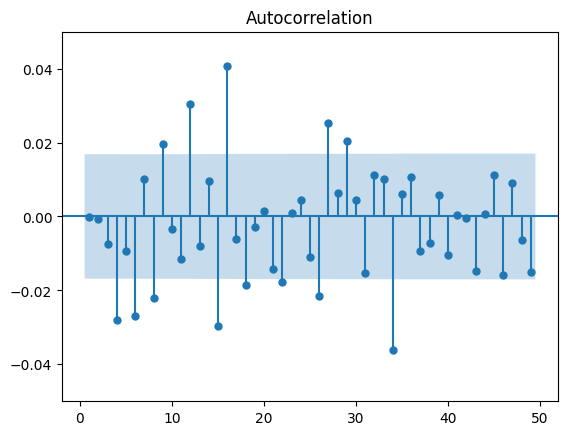

[ 1.00000000e+00 -1.08795138e-04 -5.58598481e-04 -7.40673724e-03
 -2.80613617e-02 -9.30979343e-03 -2.69886868e-02  1.02231122e-02
 -2.19771731e-02  1.96665705e-02 -3.32920322e-03]


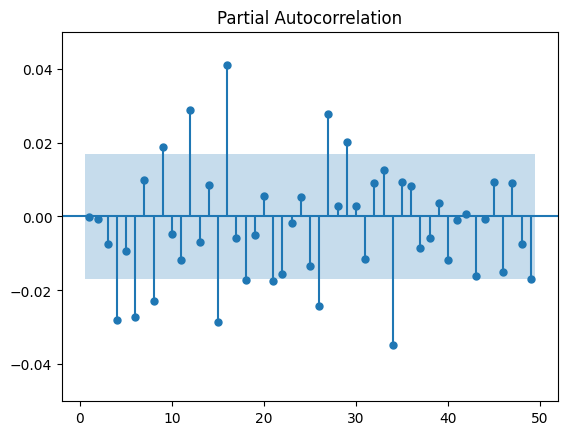

[ 1.00000000e+00 -1.08803157e-04 -5.58692673e-04 -7.40849918e-03
 -2.80731420e-02 -9.34156909e-03 -2.71210323e-02  9.77884525e-03
 -2.29984614e-02  1.87986766e-02 -4.86954111e-03]


In [178]:
model_ar = AutoReg(returns,lags=2)
results = model_ar.fit()

print(results.summary())

acf= sm.tsa.acf(results.resid,nlags=10)
fig = tsaplots.plot_acf(results.resid, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)

pacf= sm.tsa.pacf(results.resid,nlags=10)
fig = tsaplots.plot_pacf(results.resid, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

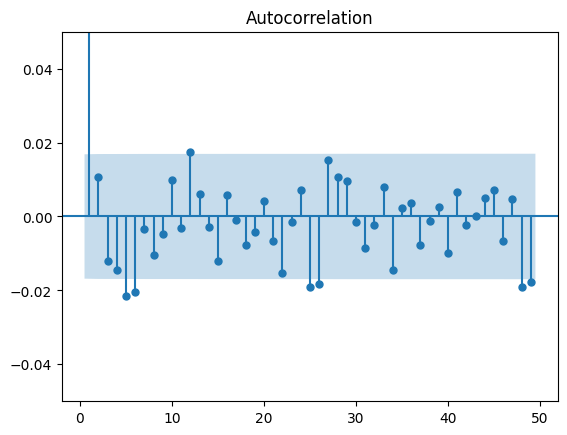

[ 1.          0.06668978  0.01071064 -0.01200783 -0.01434934 -0.02155282
 -0.02030352 -0.0033579  -0.01051891 -0.00461089  0.00982462]


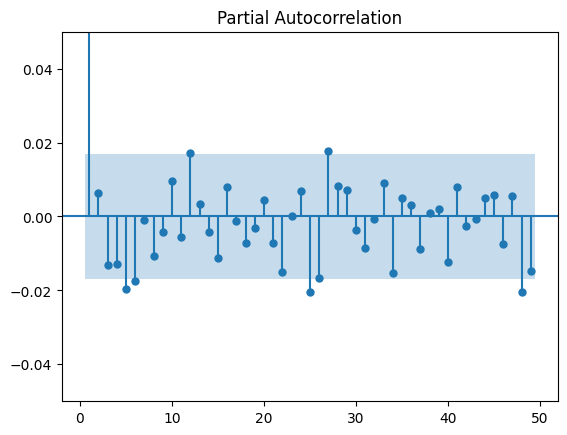

[ 1.00000000e+00  6.66946983e-02  6.29201999e-03 -1.31993173e-02
 -1.28127417e-02 -1.96314224e-02 -1.75957333e-02 -8.28643589e-04
 -1.06356383e-02 -4.19615426e-03  9.71643430e-03]


In [179]:
model_ar_garch = arch_model(results.resid,vol='GARCH',p=1,q=1)
result_ar_garch = model_ar_garch.fit(disp='off')

acf= sm.tsa.acf(result_ar_garch.std_resid,nlags=10)
tsaplots.plot_acf(result_ar_garch.std_resid, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)
pacf= sm.tsa.pacf(result_ar_garch.std_resid,nlags=10)
tsaplots.plot_pacf(result_ar_garch.std_resid,lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

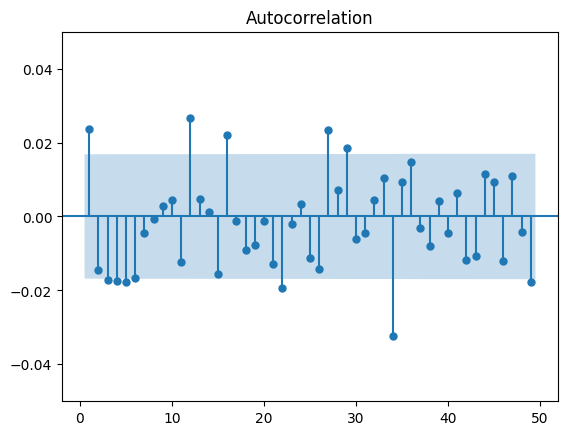

[ 1.00000000e+00  2.35799453e-02 -1.45007071e-02 -1.70713913e-02
 -1.75088851e-02 -1.77421541e-02 -1.67735619e-02 -4.57899165e-03
 -5.65859870e-04  2.92398447e-03  4.47648954e-03]


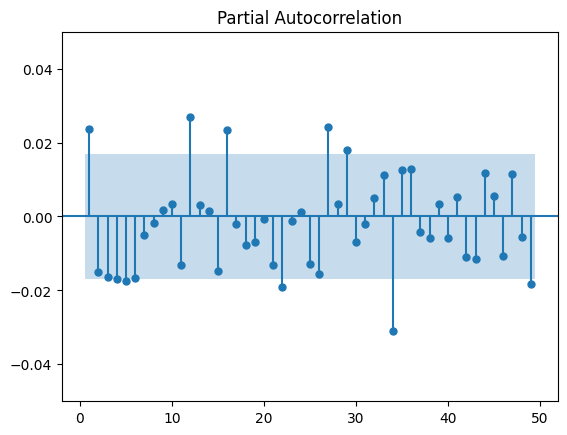

[ 1.          0.02358168 -0.01506732 -0.01638553 -0.01695379 -0.01744884
 -0.01677036 -0.00491065 -0.00173525  0.00167616  0.00330767]


In [180]:
model_arch = arch_model(returns,vol="ARCH",p=1)
result = model_arch.fit(disp='off')

acf= sm.tsa.acf(result.std_resid,nlags=10)
tsaplots.plot_acf(result.std_resid, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)
pacf= sm.tsa.pacf(result.std_resid,nlags=10)
tsaplots.plot_pacf(result.std_resid,lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

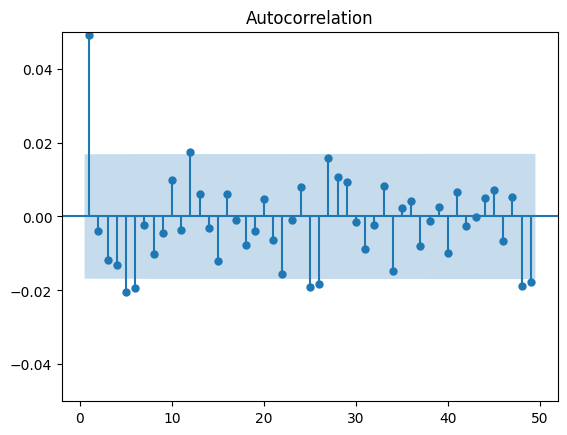

[ 1.          0.04916904 -0.0039579  -0.01174909 -0.01325439 -0.02056782
 -0.0194431  -0.00227375 -0.01003641 -0.00444136  0.00975169]


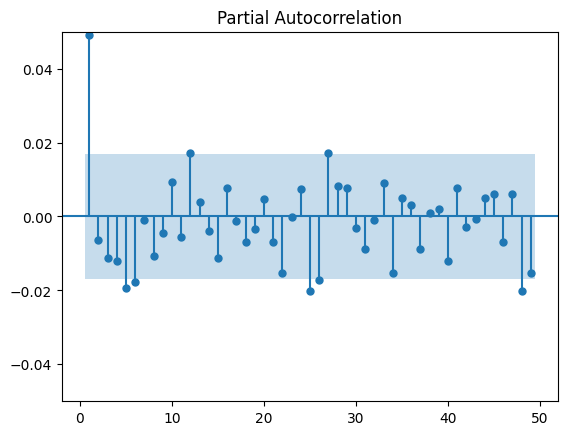

[ 1.00000000e+00  4.91726587e-02 -6.39188703e-03 -1.12691980e-02
 -1.21780281e-02 -1.94881237e-02 -1.77919294e-02 -9.38274106e-04
 -1.07107206e-02 -4.37198774e-03  9.23703185e-03]


In [181]:
model_garch = arch_model(returns,vol="GARCH",p=1,q=1)
result = model_garch.fit(disp='off')

acf= sm.tsa.acf(result.std_resid,nlags=10)
tsaplots.plot_acf(result.std_resid, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)
pacf= sm.tsa.pacf(result.std_resid,nlags=10)
tsaplots.plot_pacf(result.std_resid,lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

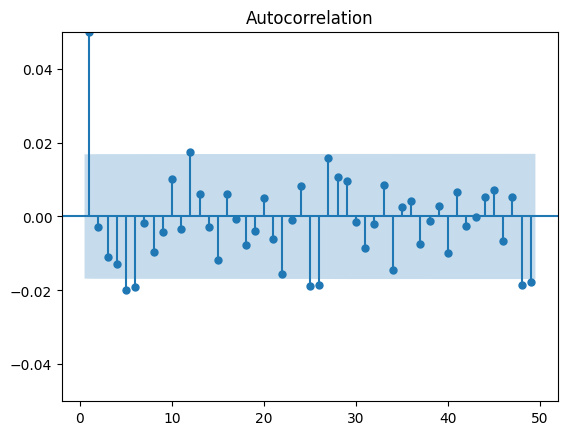

[ 1.          0.04997037 -0.00290837 -0.0110134  -0.012921   -0.02002013
 -0.01897232 -0.0017996  -0.00949381 -0.00417435  0.01020547]


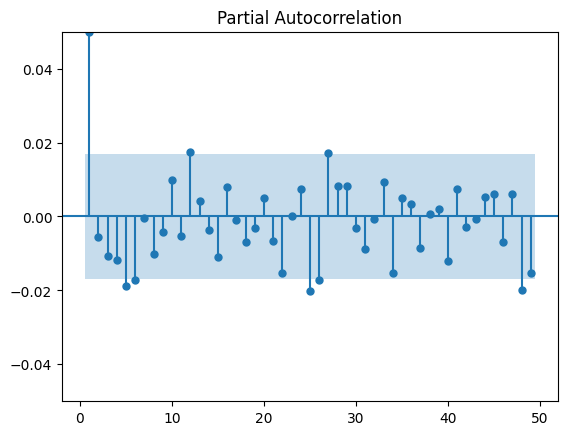

[ 1.00000000e+00  4.99740489e-02 -5.41973477e-03 -1.06256811e-02
 -1.18865300e-02 -1.89227105e-02 -1.73009346e-02 -4.11353042e-04
 -1.01238474e-02 -4.07301666e-03  9.75611069e-03]


In [182]:
log_returns = np.log(df['adjclose']/df['adjclose'].shift(1))[1:] *100

model_log_garch = arch_model(log_returns,vol='GARCH',p=1,q=1)
results_log_garch = model_log_garch.fit(disp='off')

acf= sm.tsa.acf(results_log_garch.std_resid,nlags=10)
tsaplots.plot_acf(results_log_garch.std_resid, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)
pacf= sm.tsa.pacf(results_log_garch.std_resid,nlags=10)
tsaplots.plot_pacf(results_log_garch.std_resid,lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

After this analysis lets compare some garch models to make sure that we have the best fitt for our data

In [183]:
model1 = arch_model(returns,vol="GARCH",p=1,q=1)
results1 = model1.fit(disp='off')

model2 = arch_model(returns,vol="GARCH",p=2,q=1)
results2 = model2.fit(disp='off')

model3 = arch_model(returns,vol="GARCH",p=3,q=1)
results3 = model3.fit(disp='off')

model4 = arch_model(returns,vol="GARCH",p=4,q=1)
results4 = model4.fit(disp='off')

In [184]:
print(results1.aic)
print(results2.aic)
print(results3.aic)
print(results4.aic)
print(results1.bic)
print(results2.bic)
print(results3.bic)
print(results4.bic)
print(results1.loglikelihood)
print(results2.loglikelihood)
print(results3.loglikelihood)
print(results4.loglikelihood)

35516.80171240965
35518.80171247177
35520.801712309185
35522.801712445726
35546.86447417798
35556.38016468218
35565.89585496167
35575.41154554029
-17754.400856204826
-17754.400856235887
-17754.400856154592
-17754.400856222863


In [185]:
model1 = arch_model(returns,vol="GARCH",p=1,q=1)
results1 = model1.fit(disp='off')

model2 = arch_model(returns,vol="GARCH",p=1,q=2)
results2 = model2.fit(disp='off')

model3 = arch_model(returns,vol="GARCH",p=1,q=3)
results3 = model3.fit(disp='off')

model4 = arch_model(returns,vol="GARCH",p=1,q=4)
results4 = model4.fit(disp='off')

In [186]:
print(results1.aic)
print(results2.aic)
print(results3.aic)
print(results4.aic)
print(results1.bic)
print(results2.bic)
print(results3.bic)
print(results4.bic)
print(results1.loglikelihood)
print(results2.loglikelihood)
print(results3.loglikelihood)
print(results4.loglikelihood)

35516.80171240965
35518.56739966859
35518.39821555378
35520.32606735519
35546.86447417798
35556.145851878995
35563.49235820627
35572.93590044976
-17754.400856204826
-17754.283699834294
-17753.19910777689
-17753.163033677596


After this comparisons we can see that the best GARCH model to model our data is GARCH(1,1)

# Final model

We divided our model in train and test sets

In [187]:
train_size = 0.8
train_data, test_data = train_test_split(returns, train_size=train_size, shuffle=False)

In [188]:
model_final = arch_model(train_data,vol="GARCH",p=1,q=1)

results_final = model_final.fit(disp='off')
print(results_final.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:               adjclose   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -14317.2
Distribution:                  Normal   AIC:                           28642.4
Method:            Maximum Likelihood   BIC:                           28671.6
                                        No. Observations:                10856
Date:                Tue, Jan 16 2024   Df Residuals:                    10855
Time:                        15:18:40   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0506  8.043e-03      6.292  3.140e-10 [3.

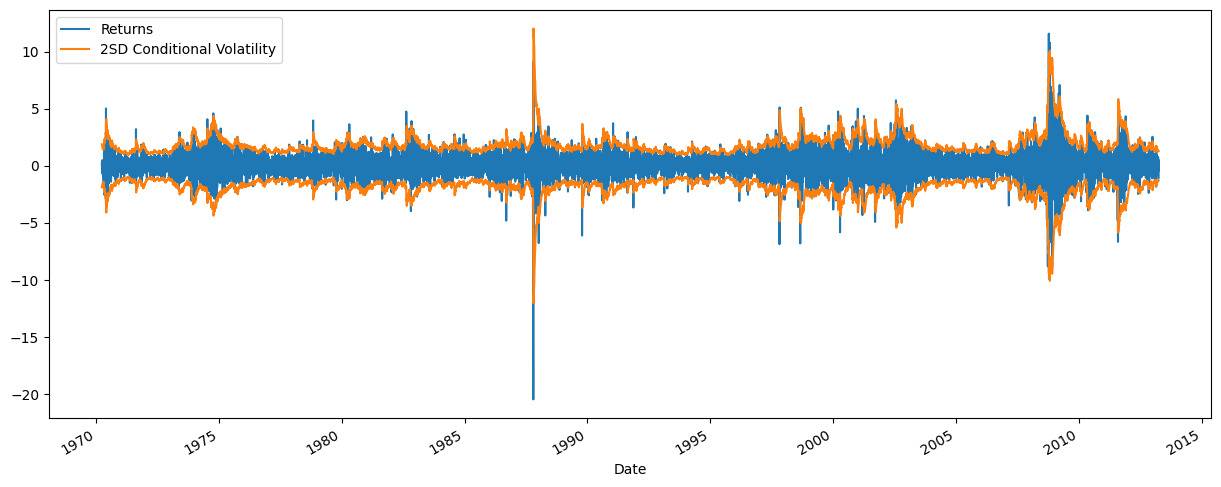

In [189]:
plt.subplots(figsize=(15, 6))

train_data.plot(label='Returns')

(2 * results_final.conditional_volatility).plot(color='C1',label='2SD Conditional Volatility')

(-2 * results_final.conditional_volatility).rename('').plot(color='C1')

plt.xlabel('Date')

plt.legend()
plt.show()

By the plot we can see that the model is fitting our data really well, to make sure that our model is appropriate we need to analyze the residuals.

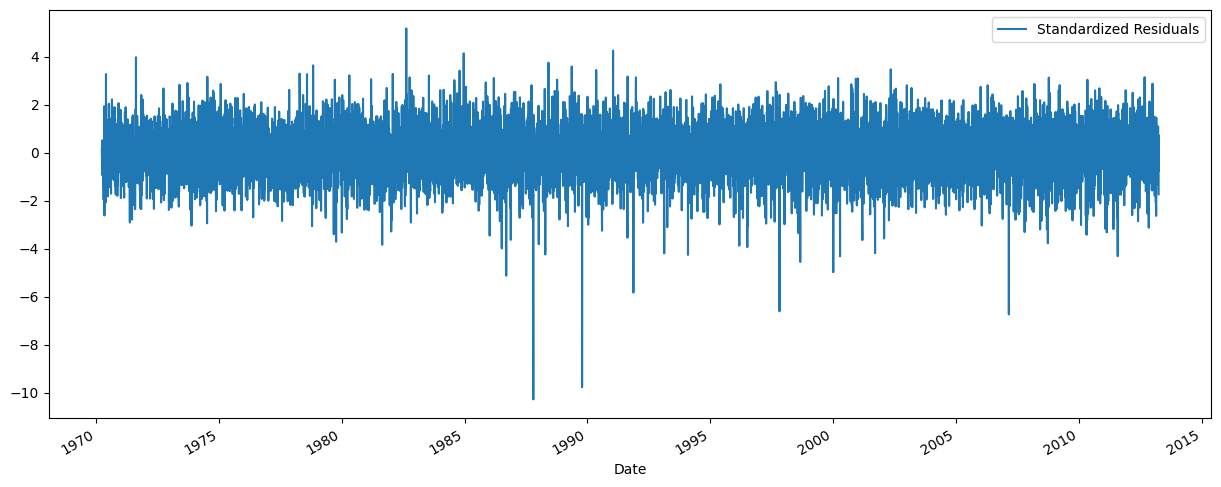

In [190]:
plt.subplots(figsize=(15, 6))

results_final.std_resid.plot(label='Standardized Residuals')

plt.xlabel('Date')
plt.legend()
plt.show()

The plot of the residuals looks good. The residuals have a consistent mean and spread over time.

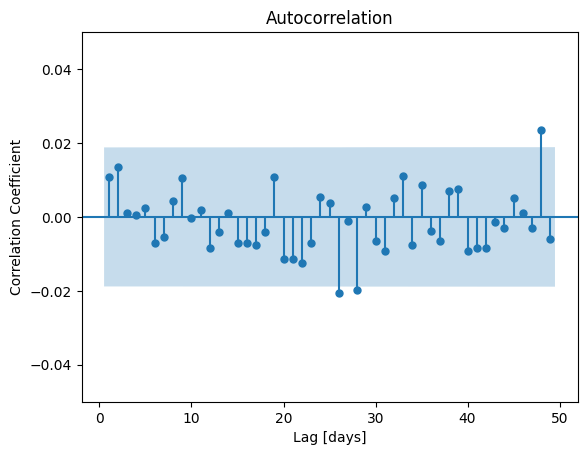

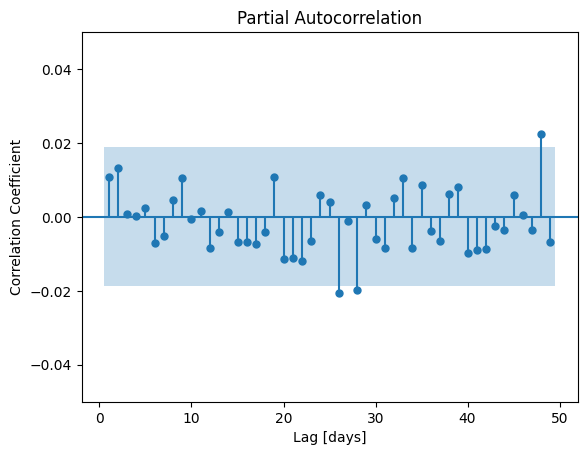

In [191]:
tsaplots.plot_acf(results_final.std_resid**2, lags=range(1,50))

plt.ylim([-0.05,0.05])
plt.xlabel('Lag [days]')
plt.ylabel('Correlation Coefficient')
plt.show()

tsaplots.plot_pacf(results_final.std_resid**2, lags=range(1,50))

plt.ylim([-0.05,0.05])
plt.xlabel('Lag [days]')
plt.ylabel('Correlation Coefficient')
plt.show()

The ACF and PACF of the residuals look like white noise another sign that our model is able to explain the data.

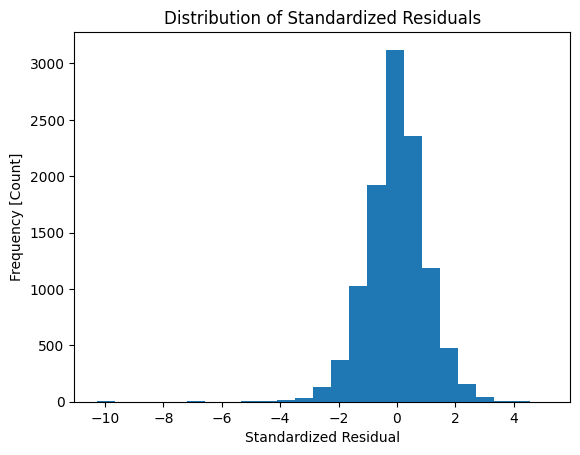

In [192]:
plt.hist(results_final.std_resid, bins=25)

plt.xlabel('Standardized Residual')
plt.ylabel('Frequency [Count]')

plt.title('Distribution of Standardized Residuals')
plt.show()

The histogram tells us that the residuals have a distribution simmilar to normal, to confirm this we will take a look at the density function compared to the density of a normal distribution.

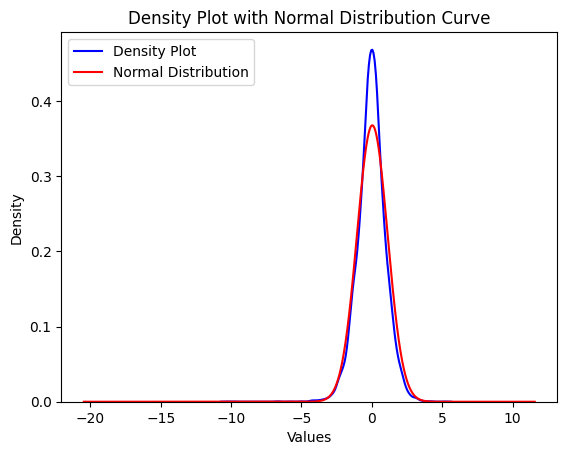

In [193]:
sns.kdeplot(results_final.std_resid, label='Density Plot', color='blue')
x = pd.Series(np.arange(min(returns), max(returns), 0.001))

# ??????
plt.plot(x, norm.pdf(x, loc=returns.mean(), scale=returns.std()), color='red', label='Normal Distribution')
plt.title('Density Plot with Normal Distribution Curve')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.show()

We can also look at the residuals over our fitted values and to a Q-Q plot of the residuals.

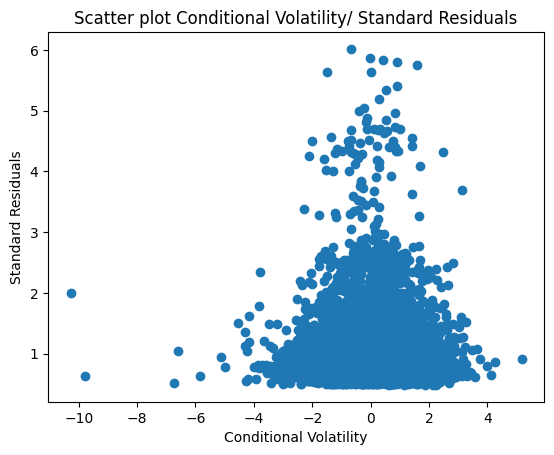

In [194]:
plt.scatter(x= results_final.std_resid, y= results_final.conditional_volatility)
plt.title('Scatter plot Conditional Volatility/ Standard Residuals')
plt.xlabel('Conditional Volatility')
plt.ylabel('Standard Residuals')
plt.show()

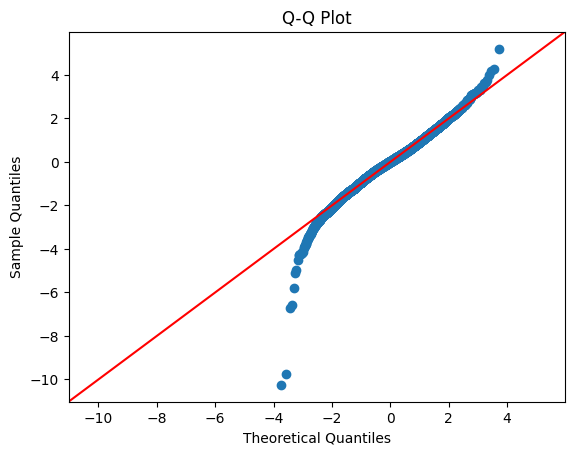

In [195]:
sm.qqplot(results_final.std_resid, line='45', fit=True)
plt.title('Q-Q Plot')
plt.show()

After analyzing this plots we can confidently say that the residuals of our model resemble white noise, a sign that our model is adequate for our data.

Finnaly lets take a look at the predicitons of our model

In [196]:
predictions = []

test_size = int(len(returns) *0.2)

for i in range(test_size):
    train_data_loop = returns.iloc[:-(test_size-i)]

    model = arch_model(train_data_loop,vol="GARCH",p=1,q=1)
    results_arch = model.fit(disp='off')

    forecasts = results_arch.forecast(horizon=1,reindex=False)
    next_pred = forecasts.variance.iloc[0,0] ** 0.5

    predictions.append(next_pred)
    


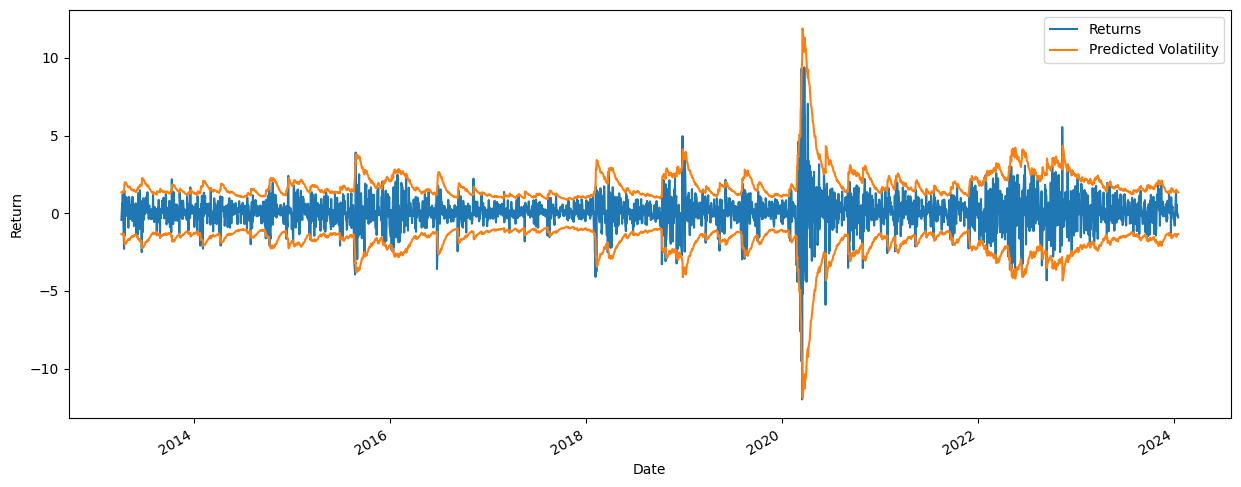

In [197]:
data_test_wfv = pd.Series(predictions, index=returns.tail(test_size).index)

plt.subplots(figsize=(15, 6))
returns.tail(test_size).plot( label="Returns")

(2 * data_test_wfv).plot(c="C1", label="Predicted Volatility")
(-2 * data_test_wfv).plot(c="C1")

plt.xlabel("Date")
plt.ylabel("Return")

plt.legend()
plt.show()

In [206]:
num_bootstrap_samples = 100

num_values = 10
table=[['observed','high_boot','low_boot','high_gaus','low_gaus']]

lower_boot = []
upper_boot = []

for i in range(num_values):
    train_data_loop = returns.iloc[:-(num_values-i)]

    model = arch_model(train_data_loop,vol="GARCH",p=1,q=1)
    results_arch = model.fit(disp='off')

    residuals = results_arch.std_resid

    boot_sample = []

    for j in range(num_bootstrap_samples):
        sample = np.random.choice(residuals,size=len(residuals),replace=True)
        bootstrap_series = results_arch.conditional_volatility + sample
        
        model_boot = arch_model(bootstrap_series,vol='GARCH',p=1,q=1)
        results_boot = model_boot.fit(disp='off')

        forecast = results_boot.forecast(horizon=1,reindex=False)
        boot_pred = forecast.variance.iloc[0,0] ** 0.5

        boot_sample.append(boot_pred)    
    
    lower_boot.append(np.percentile(boot_sample,2.5,axis=0))
    upper_boot.append(np.percentile(boot_sample,97.5,axis=0))

for i in range(num_values):
    table.append([returns.iloc[len(returns)-num_values+i-1],2 * upper_boot[i],-2 * lower_boot[i],2 * data_test_wfv.iloc[len(data_test_wfv)-num_values+i-1],-2 * data_test_wfv.iloc[len(data_test_wfv)-num_values+i-1]])

print(tabulate(table, tablefmt="fancy_grid"))

╒══════════════════════╤════════════════════╤═════════════════════╤════════════════════╤═════════════════════╕
│ observed             │ high_boot          │ low_boot            │ high_gaus          │ low_gaus            │
├──────────────────────┼────────────────────┼─────────────────────┼────────────────────┼─────────────────────┤
│ -0.2826475013374963  │ 2.408263158365489  │ -1.9251439041945788 │ 1.3945954213336653 │ -1.3945954213336653 │
├──────────────────────┼────────────────────┼─────────────────────┼────────────────────┼─────────────────────┤
│ -0.5660579005492328  │ 2.544296060093735  │ -1.9149947459733137 │ 1.3597184715317392 │ -1.3597184715317392 │
├──────────────────────┼────────────────────┼─────────────────────┼────────────────────┼─────────────────────┤
│ -0.8016314922730805  │ 2.4578448933532346 │ -1.8825166379357694 │ 1.3633007241180761 │ -1.3633007241180761 │
├──────────────────────┼────────────────────┼─────────────────────┼────────────────────┼─────────────────────┤
│

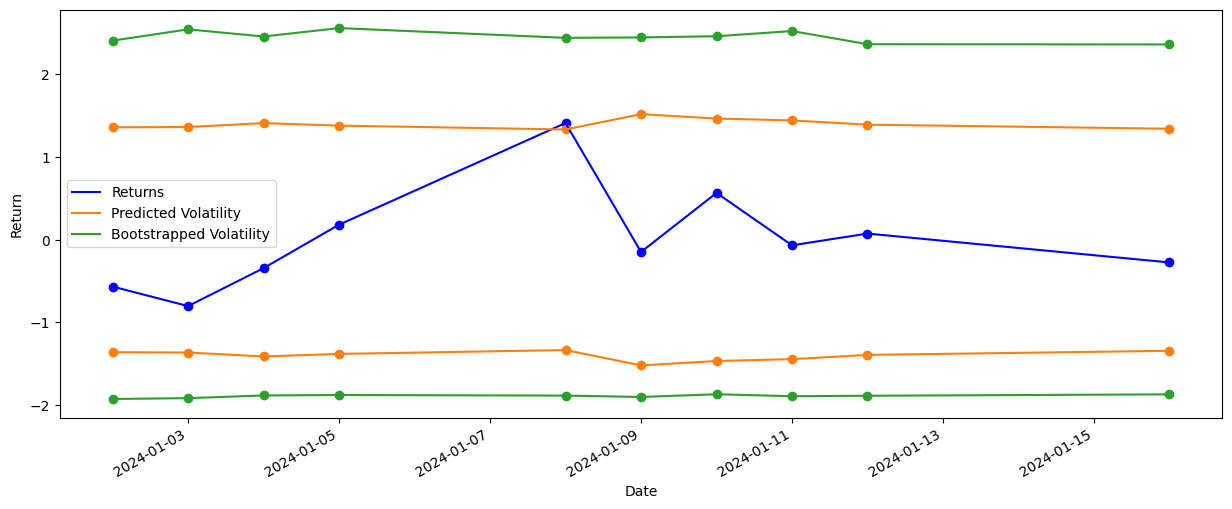

In [218]:
plt.subplots(figsize=(15, 6))
plt.scatter(x= returns.tail(num_values).index,y=returns.tail(num_values),color='blue')
plt.plot(returns.tail(num_values),label="Returns",color='blue')

(2 * data_test_wfv.tail(num_values)).plot(c="C1", label="Predicted Volatility")
(-2 * data_test_wfv.tail(num_values)).plot(c="C1")
plt.scatter(returns.tail(num_values).index,2 * data_test_wfv.tail(num_values),c="C1")
plt.scatter(returns.tail(num_values).index,-2 * data_test_wfv.tail(num_values),c="C1")

upper_boot = pd.Series(upper_boot, data_test_wfv.tail(num_values).index)
lower_boot = pd.Series(lower_boot, data_test_wfv.tail(num_values).index)

plt.plot(2 * upper_boot,c="C2", label="Bootstrapped Volatility")
plt.plot(-2 * lower_boot,c="C2")
plt.scatter(returns.tail(num_values).index,2 * upper_boot,c="C2")
plt.scatter(returns.tail(num_values).index,-2 *lower_boot,c="C2")

plt.xlabel("Date")
plt.ylabel("Return")

plt.legend()
plt.show()

The predictions shows us that the model was able to capture our data farily well, being able to represent periods of low or high volatility.

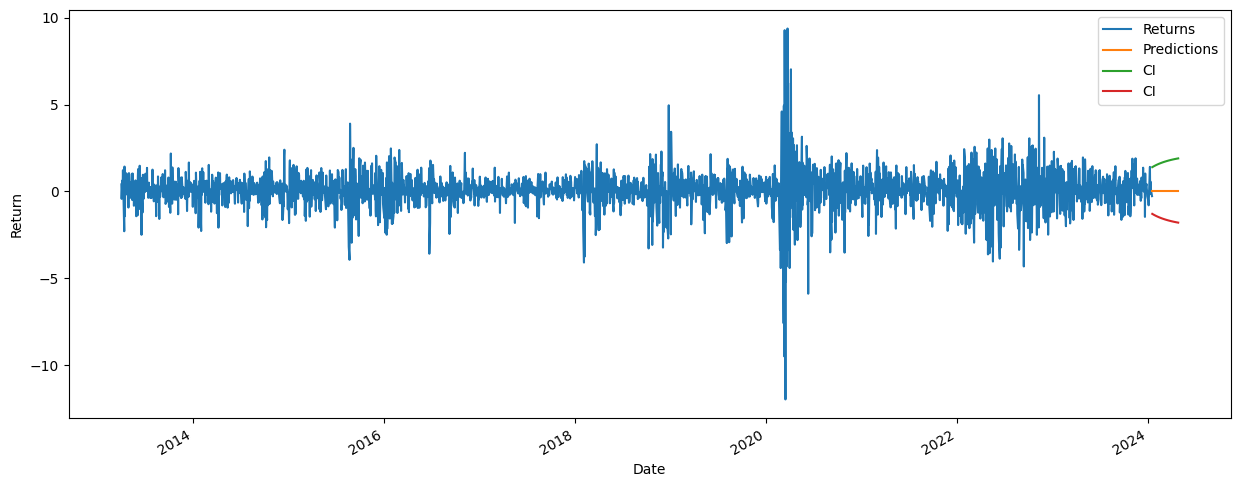

In [199]:
h = 100

forecasts = results_final.forecast(horizon=h)
date = returns.tail(1).index
confidence_interval = 1.96 * np.sqrt(forecasts.variance)

new = pd.Series()
ci_upper = pd.Series()
ci_lower = pd.Series()
for i in range(h):
    date = date + timedelta(1)
    if len(new) != 0:
        new = pd.concat([new,pd.Series(forecasts.mean.iloc[0,i],index=date)])
        ci_upper = pd.concat([ci_upper,pd.Series(confidence_interval.iloc[0,i] + forecasts.mean.iloc[0,i],index=date)])
        ci_lower = pd.concat([ci_lower,pd.Series(forecasts.mean.iloc[0,i] - confidence_interval.iloc[0,i] ,index=date)])
    else: 
        new = pd.Series(forecasts.mean.iloc[0,i],index=date)
        ci_upper = pd.Series(confidence_interval.iloc[0,i] + forecasts.mean.iloc[0,i],index=date)
        ci_lower = pd.Series(forecasts.mean.iloc[0,i] - confidence_interval.iloc[0,i],index=date)
        

plt.subplots(figsize=(15, 6))

test_data.plot(label='Returns')
new.plot(label='Predictions')
ci_upper.plot(label='CI')
ci_lower.plot(label='CI')

plt.xlabel("Date")
plt.ylabel("Return")

plt.legend()
plt.show()